<a href="https://colab.research.google.com/github/Anastasios-K/Classification/blob/master/last_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup dependencies

In [2]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/jpauwels/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

/content/city_dsp_ap


In [0]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display

## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [0]:
%ls audio/*.wav

audio/carrier.wav*  audio/rockA.wav  audio/rockB.wav


#### UG
Program a controllable delay line. Mix the output with the original input to create a flanging effect. Use the control signal to vary the amount of delay between zero and a maximum value (1 millisecond would be a good default for this, use the samplerate to calculate how much samples this is).

#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time in response to a control signal. Apply the filter to the signal by implementing a convolution with the filter coefficients in a loop over the samples, just like in lab 6. In order to make the filter respond to the control signal, you can either design two static filters and interpolate between them (like in lab 6), or you can directly manipulate the filter characteristics in the filter design function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

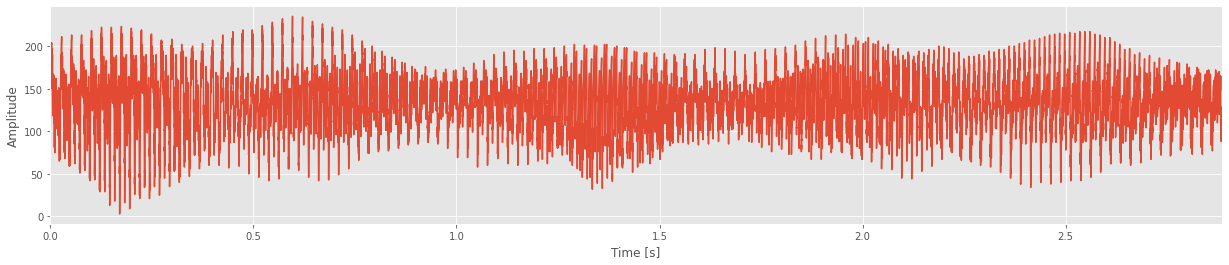

In [0]:
######################################################
#               MY CODE starts here
######################################################

# Signal upload and visualisation
Path = 'audio/carrier.wav'

def Orginal_siganl(path):
    samplerate, data = wavfile.read(path)
    length = data.shape[0] / samplerate
    time = np.linspace(0., length, data.shape[0])

    plt.style.use('ggplot')
    figure = plt.figure(figsize=(21, 4))
    plt.plot(time, data)
    plt.xlim(time[0], time[-1])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    return(figure, samplerate, data, time)

figure, rate, original_sig, time = Orginal_siganl(path = Path)

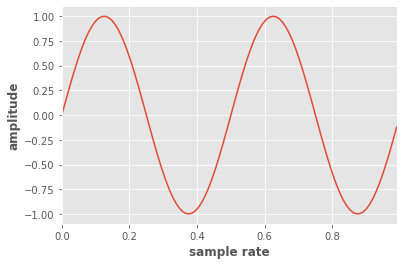

In [0]:
# Desinging the control 2Hz sive-wave filter
filter_length = 101
Frequency = 2 # frequency in Hz
sample_rate = filter_length # the sample rate is larger than 4 (the double size of frequency); So, it does not violate the Nyquist frequency assumption
Amplitude = 1 # The amplitude is randomly set at 0.5

def Sine_2Hz_and_plot(frequency, amplitude, sample_rate):
  sine_time_points = np.arange(sample_rate) / sample_rate
  sine_wave = amplitude * np.sin(2 * np.pi * frequency * sine_time_points)
  plt.style.use('ggplot')
  figure = plt.plot(sine_time_points, sine_wave)
  plt.xlim(sine_time_points[0], sine_time_points[-1])
  plt.xlabel("sample rate", weight = 'bold')
  plt.ylabel("amplitude", weight = 'bold')
  return (sine_wave, figure)

control_filter, fig = Sine_2Hz_and_plot(Frequency, Amplitude, sample_rate)

In [0]:
original_filter = signal.firls(filter_length, [0, 500, 1100, 1400, 2000, rate/2], [0, 0, 1, 1, 0, 0], fs=rate)

In [0]:
# 10 time steps are generated and consequently 10 different mix of filters
# The bigger the time step, the greater the alteration of the original filter
# So, the bigger the time step, the greater the effect of the control filter

time_steps = 20
filter_list = []

for step in range(time_steps):
    mix_ratio = step/(time_steps-1)
    filter_mix = (1-mix_ratio) * original_filter + mix_ratio * control_filter
    filter_list.append(filter_mix)



In [0]:
################################################################### AYTO EINAI GIA POULO SIGOURA META TO TEST
# original_sig = original_sig[0:300]
#####################################################################

# original_sig_padding = np.pad(original_sig, (filter_length-1, filter_length-1), 'constant', constant_values=(0,0))


In [0]:
# adding the required padding of zeros into both sides of the original signal
sig_padd = np.pad(original_sig, (filter_length-1, filter_length-1), 'constant', constant_values=(0,0))

# Comment out the 2 lines below to ensure that the padding has been properly added into both sides
# print(f"The first 102 elements of the original filter plus the padding {sig_padd[0:filter_length]}")
# print(f"The last 102 elements of the original filter plus the padding {sig_padd[-filter_length:]}")

# preparing a list of indicators for the filter selection process
index_list = np.arange(0, len(sig_padd)-filter_length+1, 1)
index_parts = np.array_split(index_list, time_steps)

# an empty list to append the output siganl points
output_signal = []

# the final return of the loop below is output signal after the convolution
for i in range(len(sig_padd)-filter_length+1):
    if i <= len(sig_padd)-filter_length:
        part_to_convolv = sig_padd[i:filter_length+i] # selecting the appropriate part of the original siganl to be convolved 
        
        for ind in range(time_steps):
            filter_selection = list(filter(lambda x: x == i, index_parts[ind])) # selecting the corresponding filter mix depending on the time point
            if len(filter_selection) > 0:
                current_filter = np.flip(filter_list[ind]) # flip the filter
                # print(part_to_convolv) # to test that we get the correct pairs of (part of siganl, filter to be used)
                # print(current_filter)
                
                convolved_signal_point = np.dot(part_to_convolv, current_filter)
                output_signal.append(convolved_signal_point)
                break


Text(0, 0.5, 'Amplitude')

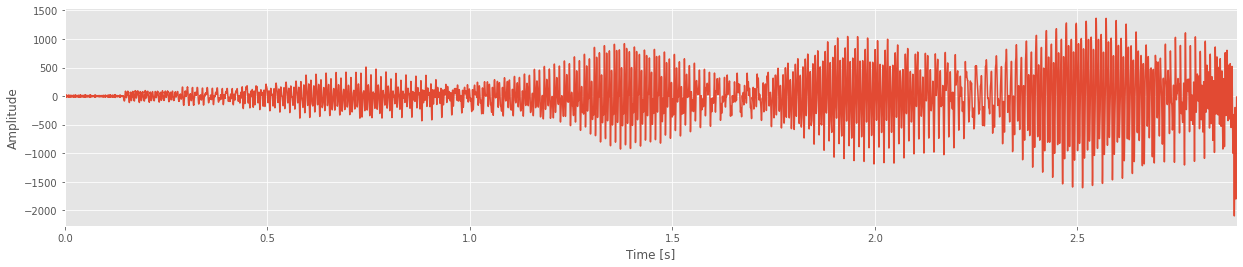

In [0]:
# Plot the output signal

length = np.array(output_signal).shape[0] / rate
time = np.linspace(0., length, np.array(output_signal).shape[0])
plt.style.use('ggplot')
figure = plt.figure(figsize=(21, 4))
plt.plot(time, output_signal)
plt.xlim(time[0], time[-1])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [197]:
%ls data/digits-*.txt

data/digits-test.txt*  data/digits-training.txt*


In [0]:
from itertools import islice
import re

def read_digit_pixels_and_labels(path):
    with open(path) as f:
        header = list(islice(f, 21))
        pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
        num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
        digit_pixels = []
        labels = []
        for _ in range(num_digits):
            chunk = list(islice(f, pixel_height+1))
            digit_pixels.append(np.loadtxt(chunk[:-1]))
            labels.append(int(chunk[-1]))
    return digit_pixels, labels

Since the text files have a custom format, a loader function `read_digit_pixels_and_labels` is provided.

In [0]:
training_digits, training_labels = read_digit_pixels_and_labels('data/digits-training.txt')
test_digits, test_labels = read_digit_pixels_and_labels('data/digits-test.txt')

In [200]:
len(training_digits), len(training_labels), len(test_digits), len(test_labels)

(1934, 1934, 943, 943)

All digits and their associated labels have now been read into lists, so we can use list indexing to access them and, for instance, display them as below.

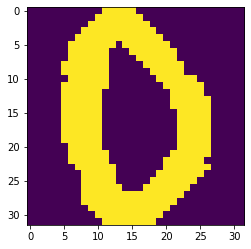

Image of digit 0


In [201]:
index = 1
plt.figure()
plt.imshow(training_digits[index])
plt.show()
print('Image of digit {}'.format(training_labels[index]))

Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

In [0]:
# write your code here
from skimage.transform import rotate
from skimage.util import invert, random_noise

In [69]:
# 2 idia digits from training and test sets
print(training_labels[0])
print(test_labels[11])

0
0


In [206]:
# The main model

def Classifier(training_digits, test_digits, training_labels, test_labels):
    matching_list = [] # empty list to save the matching pairs
    predictions = [] # empty list to save the the predictions only
    for i in range(len(test_digits)):
        saved_corr = 0 # reset the correlation value to minimum for each digit in the test set
        for x in range(len(training_digits)):
            correlation = signal.correlate2d(test_digits[i], training_digits[x], mode='valid') # calculating the 2d correlation
            max_corr = np.max(correlation)
            if saved_corr < max_corr: # Only correlation values higher than the latest saved corralation can pass
                saved_corr = max_corr
                new_matching = ([test_labels[i],training_labels[x]])
        predictions.append(new_matching[1])
        matching_list.append(new_matching)
    return(predictions,matching_list)

predictions, matching_list = Classifier(training_digits, test_digits, training_labels, test_labels)

ERROR! Session/line number was not unique in database. History logging moved to new session 72


In [209]:
def Accuracy(predictions, test_labels):
    diff = abs(np.array(predictions) - np.array(test_labels)) #difference between predictions and targets (non zero values indicate a mistaken prediction)
    accuracy = (len(predictions) - np.count_nonzero(diff)) / len(predictions) # calcualting the accuracy (correct predictions / total predictions)
    return(accuracy)

accuracy = Accuracy(predictions, test_labels)

print(f"The model accuracy is {np.round(accuracy*100,2)}%")

The model accuracy is 90.14%


In [0]:
# Applying changes to the original train and test sets

# Generating negatives
neg_train_digits = []
neg_test_digits = []

for train_i in range(len(training_digits)):
    neg_image = 256-1-training_digits[train_i]
    neg_train_digits.append(neg_image)

for test_i in range(len(test_digits)):
    neg_image = 256-1-test_digits[test_i]
    neg_test_digits.append(neg_image)

# Rotating images
rot_train_digits = []

for rot_i in range(len(training_digits)):
    rot_image = rotate(training_digits[rot_i], rng.uniform(1,90))
    rot_train_digits.append(rot_image)

# Adding ranfom noise
noisy_train_digits = []

for nois_i in range(len(training_digits)):
    noisy_image = random_noise(training_digits[nois_i], mode='gaussian', mean=0, var=0.1)
    noisy_train_digits.append(noisy_image)

In [0]:
# Using the negative images
negative_pred, neg_match_list = Classifier(neg_train_digits, neg_test_digits, training_labels, test_labels)
neg_accur = Accuracy(negative_pred, test_labels)
print(f"The model accuracy is {np.round(neg_accur*100,2)}%")

In [218]:
# Using rotating images
rotat_pred, rotat_match_list = Classifier(rot_train_digits, test_digits, training_labels, test_labels)
rotat_accur = Accuracy(rotat_pred, test_labels)
print(f"The model accuracy is {np.round(rotat_accur*100,2)}%")

The model accuracy is 81.55%


In [219]:
# Using noisy images
noisy_pred, noisy_match_list = Classifier(noisy_train_digits, test_digits, training_labels, test_labels)
noisy_accur = Accuracy(noisy_pred, test_labels)
print(f"The model accuracy is {np.round(noisy_accur*100,2)}%")

The model accuracy is 88.76%


In [222]:
# Summary
print(f"Accuracy - Original data        -->  {np.round(accuracy*100,2)}%")
print(f"Accuracy - Negative data        -->  {np.round(neg_accur*100,2)}%")
print(f"Accuracy - Rotated training set -->  {np.round(rotat_accur*100,2)}%")
print(f"Accuracy - Noisy training set   -->  {np.round(noisy_accur*100,2)}%")

Accuracy - Original data        -->  90.14%
Accuracy - Negative data        -->  8.59%
Accuracy - Rotated training set -->  81.55%
Accuracy - Noisy training set   -->  88.76%


## Time series prediction with financial data (UG pairs & PG)

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [0]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [0]:
financial.dtype.names;

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [0]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

In [0]:
plt.figure(figsize=(10,3))
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

In [0]:
# write your code here

In [0]:
def Preprocessing(data):
    missing_vals = np.count_nonzero(np.isnan(real_price))
    minimum_val = np.min(real_price)
    print(f"--> The number of missing values is {missing_vals}") # look for missing values
    print(f"--> The minimum value of the data is {minimum_val}") # look for negative values

    print("The Outlier values") # look for outlier values
    plt.boxplot(real_price,
          showmeans = True,
          flierprops = dict(markerfacecolor='r', marker='o'))
    plt.xlabel('Real Prices')

Report_preprocessing = Preprocessing(real_price)

In [0]:
# 3 different polynomials are used with the ordes of 1,2 and 10
# As an assumption the order 10 polynomial achieves the optimal fit
# Further analysis towards the optimal fit is out of scope

time = np.linspace(0, len(date), len(date)) # generating the time data from 0 to totatl number of years

def Original_polynom(data, time):

    # fit the polynomial regressions
    p1 = np.polyfit(time, real_price, 1)
    p2 = np.polyfit(time, real_price, 2)
    p10 = np.polyfit(time, real_price, 10)

    y_new_p1 = np.poly1d(p1)
    y_new_p2 = np.poly1d(p2)
    y_new_p10 = np.poly1d(p10)
    
    # plot the original data and the estimated values linked to the 3 polynomial regressions
    plt.figure(figsize=(10,4))
    plt.plot(time, y_new_p1(time), '--r', label= 'order 1 Polynom')
    plt.plot(time, y_new_p2(time), '--b', label= 'order 2 Polynom')
    plt.plot(time, y_new_p10(time), '--g', label= 'order 3 Polynom')
    plt.plot(time, real_price, '-k', label= 'Original price')
    plt.legend()
    plt.ylim(0, np.max(real_price)+100)

original_polynom = Original_polynom(real_price, time)

In [0]:
# Implementing the same process (like the last step) using a resacled data (log10 transformation)

log_real_price = np.log(real_price) # rescaling the data using a log10 transoframtion

def Log10_polynom(data, time):

    # fit the polynomial regressions
    log_p1 = np.polyfit(time, log_real_price, 1)
    log_p2 = np.polyfit(time, log_real_price, 2)
    log_p10 = np.polyfit(time, log_real_price, 10)

    ylog_new_p1 = np.poly1d(log_p1)
    ylog_new_p2 = np.poly1d(log_p2)
    ylog_new_p10 = np.poly1d(log_p10)

    # plot the original data and the estimated values linked to the 3 polynomial regressions
    figure = plt.figure(figsize=(10,4))
    plt.plot(time, ylog_new_p1(time), '--r', label= 'order 1 Polynom')
    plt.plot(time, ylog_new_p2(time), '--b', label= 'order 2 Polynom')
    plt.plot(time, ylog_new_p10(time), '--g', label= 'order 3 Polynom')
    plt.plot(time, log_real_price, '-k', label= 'Original price')
    plt.legend()
    plt.ylim(np.min(log_real_price), np.max(log_real_price))

    estim_data = ylog_new_p10(time)
    return(figure, estim_data)

log_polynom, estimated_prices = Log10_polynom(log_real_price, time)

In [0]:
# Detrending the data by subtraction (log10 real data - estimated data)
def Detrend_data(data, estimated_data):
    detrended_data = data - estimated_data
    figure = plt.figure(figsize=(10,4))
    plt.plot(time, detrended_data, '-k', label= "Detrened data")
    plt.legend(loc='upper left')
    return(figure, detrended_data)

fig, detrended_data = Detrend_data(log_real_price, estimated_prices)

In [0]:
# 5 months are removed from the beginnig of the orginal data
# this is happening because the Halloween Effect is to be tested (lasts from November to April)
new_date = date[2:]
# print(new_date) #comment out to make sure that the correct range of date is used
new_price = detrended_data[2:] # similarly, the range of prices changes
# print(new_date)
new_time = np.linspace(0, len(new_price), len(new_price))

In [0]:
# Designing a Hamming window with specified length
filter_length = 31

def Hamming_design(filter_length):
    window = signal.hamming(filter_length, sym=False) # Designing the a Hamming window
    # plot window
    filter_fig = plt.figure(figsize=(10,4))
    plt.plot(np.linspace(0, filter_length, filter_length), window, '-b')
    plt.title("Hamming window")

    return(window, filter_fig)

hamming_win, fig = Hamming_design(filter_length)

In [0]:
# Pass the data through the filter using convolution
def Filter_data(data, filter):
    filtered_data = signal.convolve(new_price, hamming_win, 'full')
    figure = plt.figure(figsize=(10,4))
    plt.plot(filtered_data)
    plt.title("Hammin Filtered data")
    return(figure, filtered_data)

fig, hamming_data = Filter_data(new_price, hamming_win)

In [0]:
# Moving average filter made from scratch
filter_length = 31

def Moving_Average(data, filter_length):
    pad_data = np.pad(data, (filter_length-1, filter_length-1), 'constant', constant_values=(0,0))

    filtered_data=[]
    for num, i in enumerate(data):
        y = sum(pad_data[num:num+filter_length])/filter_length
        filtered_data.append(y)

    figure = plt.figure(figsize=(10,4))
    plt.plot(filtered_data)
    plt.title("Moving Average Filtered data")
    return(figure, filtered_data)

fig, moving_avg_data = Moving_Average(new_price, filter_length)

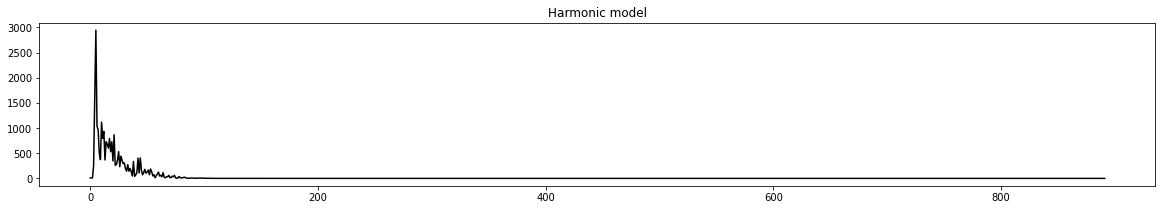

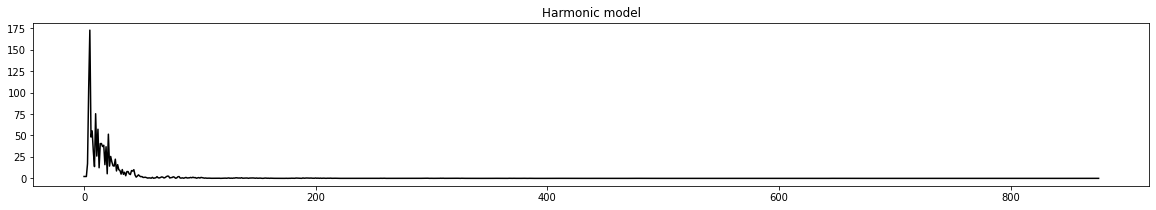

In [32]:
# Implementing DFT for the 2 two filtered data above

def DFT_model(filter_length):
    harmonic_model = fft.rfft(filter_length) # Discrete Fourier Transform

    fig = plt.figure(figsize=(20,3))
    plt.plot(abs(harmonic_model), '-k')
    plt.title('Harmonic model')

fig = DFT_model(hamming_data)
fig = DFT_model(moving_avg_data)

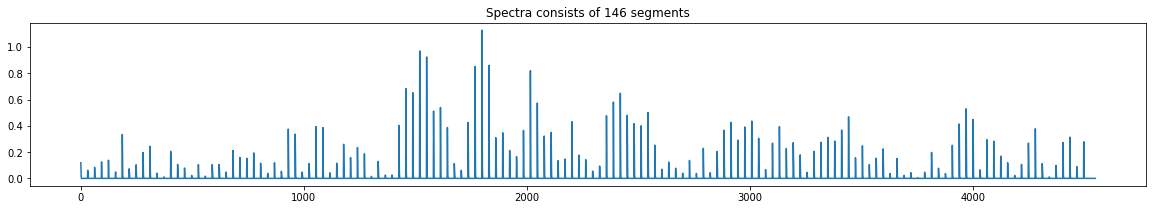

In [64]:
# Breaking original filter in segments and appluing a Hamming window
segments = np.split(new_price, 146 ) # equally splitted time series in 12 points
filter_length2 = 31 #320 - len(segments[0]) # the filter length is 8 and the final outcome is 16
DFT_length = filter_length2 + len(segments[0]) # the DFT length is long enough to avoid circular convolution
hamming_win2 = signal.hamming(filter_length2, sym=False)

def Spectra_segments(segments, filter_length, DFT_length, window):
    spectra_store = []
    padd_hamming_win2 = np.append(window, np.zeros(DFT_length-1-len(window))) # padding is added into the Hamming window
    filter_freq_response = fft.rfft(padd_hamming_win2) # get the frequency response of the window

    for num, i in enumerate(segments):
        padd_segment = np.append(segments[num], np.zeros(DFT_length-1-len(segments[num]))) # padding is added into the segment
        segment_freq_response = fft.rfft(padd_segment) # get the frequency response of the segment

        spectra = segment_freq_response*filter_freq_response # calculating the spectra of each segment by multiplying the two frequency responses as it is recommended

        final_spectra_step1 = np.append(np.zeros(num*filter_length), spectra) # extra zero padding is added at the beginning to achieve the appropriate overlapping
        final_spectra_step2 = np.append(final_spectra_step1, np.zeros((len(segments)-num)*filter_length)) # extra zero padding at the end for the same reason
        spectra_store.append(abs(final_spectra_step2))

    final_spectra = sum(spectra_store)/len(spectra_store) #sum and average the spectrum

    figure = plt.figure(figsize=(20,3))
    plt.plot(final_spectra)
    plt.title("Spectra consists of 146 segments")
    return(figure)

fig = Spectra_segments(segments, filter_length2, DFT_length, hamming_win2)